# Классификация изображений с использованием PyTorch и PyTorch Lightning

## Шаг 1: Подготовка окружения

Для начала убедитесь, что у вас установлены все необходимые библиотеки. Выполните следующие команды в вашем Jupyter Notebook для установки PyTorch, PyTorch Lightning, torchvision, scikit-learn, matplotlib и numpy

In [1]:
!pip install lightning

In [2]:
import lightning as L
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from datasets import load_dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

## Шаг 2: Загрузка и обработка данных

Мы будем работать с датасетом "Cat_and_Dog", доступным в HuggingFace Datasets.

In [3]:
ds = load_dataset("Bingsu/Cat_and_Dog")

Generating train split:   0%|          | 0/8000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Создадим класс HuggingFaceDataset, наследуя его от класса Dataset в PyTorch, для удобной работы с датасетом.

In [4]:
class HuggingFaceDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image'] 
        label = item['labels']

        if self.transform:
            image = self.transform(image)

        return image, label


Применим трансформации к изображениям, включая конвертацию в тензоры, изменение размера и нормализацию.

Создадим DataLoader'ы для обучающей, валидационной и тестовой выборок.

In [5]:
batch_size = 256

ds = ds.shuffle()

test_valid_split = ds['test'].train_test_split(test_size=0.5)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((64, 64)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = HuggingFaceDataset(ds['train'], transform=transform)
val_dataset = HuggingFaceDataset(test_valid_split['train'], transform=transform)
test_dataset = HuggingFaceDataset(test_valid_split['test'], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                          num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                          num_workers=3)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                          num_workers=3)

classes = ['cat', 'dog']

Визуализируем несколько изображений из нашего датасета.

In [6]:
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.010228485..1.0000002].


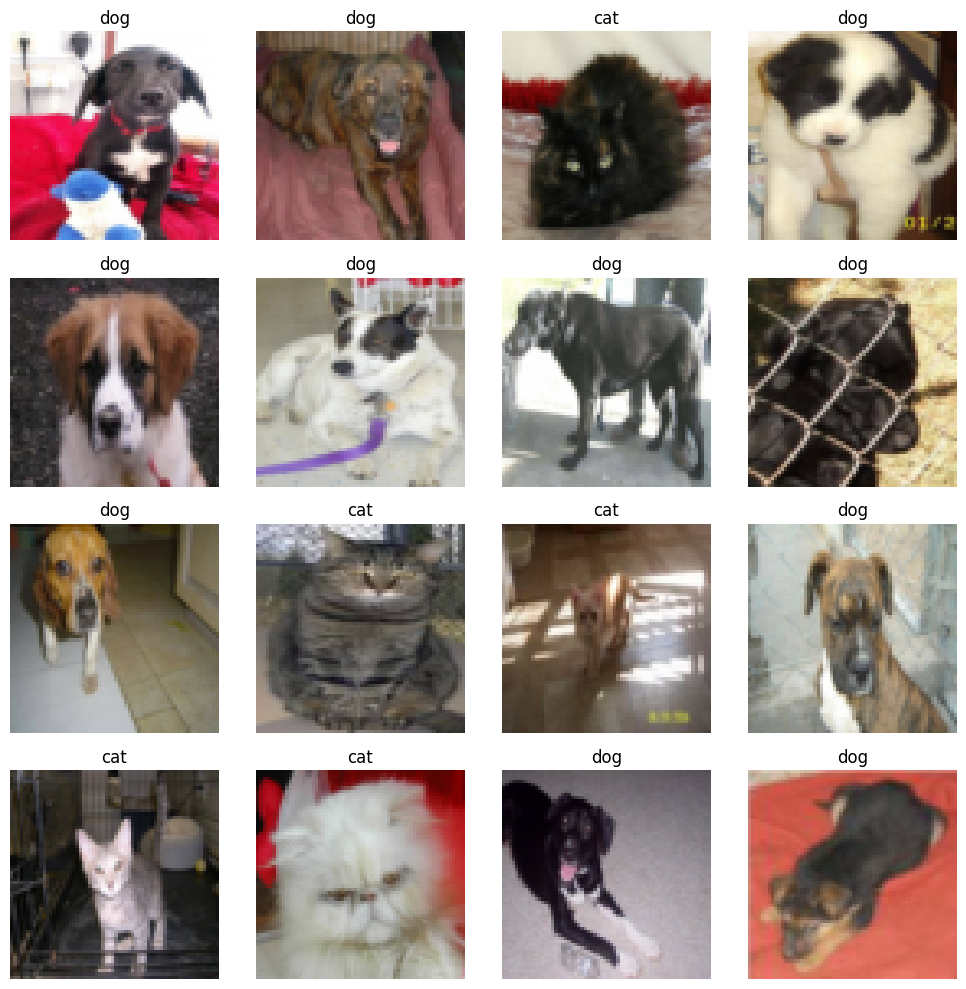

In [32]:
# Получаем один батч изображений
batch = next(iter(test_loader))
images, labels = batch

# Создаем сетку изображений
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for ax, image, label in zip(axes.flatten(), images, labels):
    ax.imshow(np.transpose((image / 2 + 0.5).numpy(), (1, 2, 0)))  # Денормализация и отображение
    ax.set_title(classes[label])
    ax.axis('off')

plt.tight_layout()
plt.show()

## Шаг 3: Создание и обучение модели

Загрузим предобученную модель ResNet-50, выходной слой модифицируем для классификации на два класса (кошки и собаки).

In [8]:
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
resnet.fc = nn.Linear(2048, 2)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 93.2MB/s]


Создадим класс LitModel, наследуемый от LightningModule, в котором определяются методы для шагов обучения, валидации, предсказания и конфигурации оптимизатора

In [33]:
class LitModel(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
#     def forward(self, batch):
#         inputs, target = batch
#         return self.model(inputs, target)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1)
        return [optimizer], [lr_scheduler]
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        val_loss = F.cross_entropy(y_hat, y)
        self.log("val_loss", val_loss)
        
    def predict_step(self, batch):
        inputs, _ = batch
        return self.model(inputs)
        
    

Инициалируем и обучим модель с использованием PyTorch Lightning Trainer на обучающей и валидационной выборках

In [35]:
lit_resnet = LitModel(resnet)
trainer = L.Trainer(max_epochs=3)

trainer.fit(model=lit_resnet, train_dataloaders=train_loader, val_dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | ResNet | 23.5 M | train
-----------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


## Шаг 4: Оценка модели

Оценим точность модели на тестовом наборе данных

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.010228485..1.0000002].


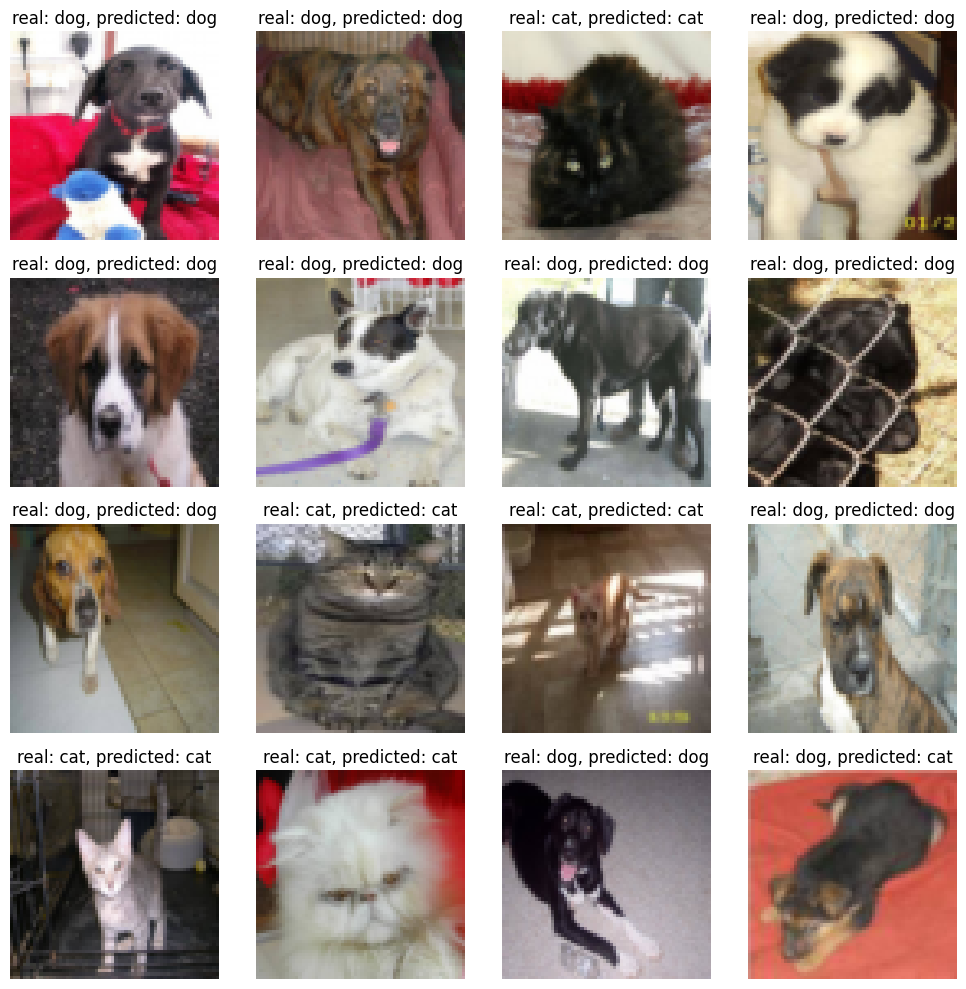

In [47]:
test_batch = next(iter(test_loader))
images, labels = test_batch

preds = lit_resnet.predict_step(test_batch)

# Получим индексы классов
preds = torch.argmax(preds, dim=1)

# Получаем один батч изображений
batch = next(iter(test_loader))
images, labels = batch

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for ax, image, label, pred in zip(axes.flatten(), images, labels, preds):
    ax.imshow(np.transpose((image / 2 + 0.5).numpy(), (1, 2, 0)))
    ax.set_title(f'real: {classes[label]}, predicted: {classes[pred]}')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [49]:
accuracy = accuracy_score(labels, predicted)
print(f'Точность модели на тестовом наборе данных: {accuracy:.2f}')

Точность модели на тестовом наборе данных: 0.93


In [50]:
!pip freeze

accelerate==0.33.0
aiohttp==3.9.5
aiosignal==1.3.1
annotated-types==0.7.0
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1717693030552/work
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1692818318753/work
argon2-cffi-bindings @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi-bindings_1695386553988/work
arrow @ file:///home/conda/feedstock_root/build_artifacts/arrow_1696128962909/work
asttokens @ file:///home/conda/feedstock_root/build_artifacts/asttokens_1698341106958/work
async-lru @ file:///home/conda/feedstock_root/build_artifacts/async-lru_1690563019058/work
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1704011227531/work
Babel @ file:///home/conda/feedstock_root/build_artifacts/babel_1702422572539/work
beautifulsoup4 @ file:///home/conda/feedstock_root/build_artifacts/beautifulsoup4_1705564648255/work
bitmath==1.3.3.1
bleach @ file:///home/conda/feedstock_root/build_artifacts/bleach_1696630167146/work
b